# Predict BBT change using Kalman Filter
**Author:** Thuy Trinh

**Achievement:**

# Introduction
Aims:
1. to explain daily  fluctuations in BBT
2. to derive a predictive  distribution of menstrual cycle length that is dependent on the **current phrase** state

## Import packages

In [273]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math as m
from numpy.linalg import inv
import scipy.optimize as opt
%matplotlib inline

# Data

## Import data

In [32]:
data = pd.read_csv("bbtdata_forTask7.csv", index_col = "day")
data.head()

,bbt_subject1,bbt_subject2,bbt_subject3,bbt_subject4,bbt_subject5
day,,,,,
0,35.95,36.19,36.41,36.56,36.65
1,35.98,36.23,36.04,36.32,36.61
2,36.10,36.20,36.01,36.21,37.00
3,36.07,36.14,36.01,36.18,36.90
4,36.00,36.37,36.03,36.16,36.65


In [33]:
print("\n initial data dimension:", data.shape)
data = data.dropna()
print("\n removed NA data dimension:", data.shape)


 initial data dimension: (254, 5)

 removed NA data dimension: (254, 5)


There is no missing data in our data. <br>
We have data for records of BBT from 5 different subjects for 254 consecutive days.

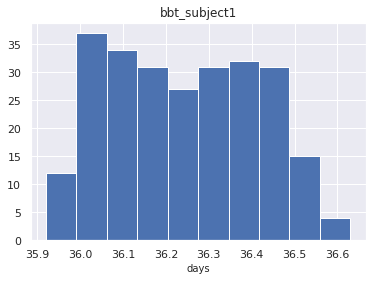

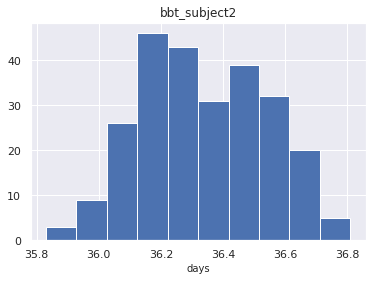

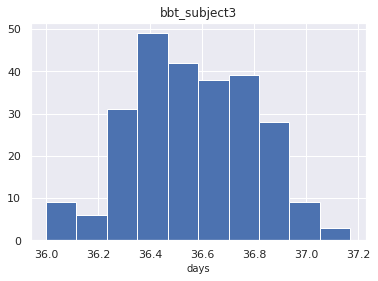

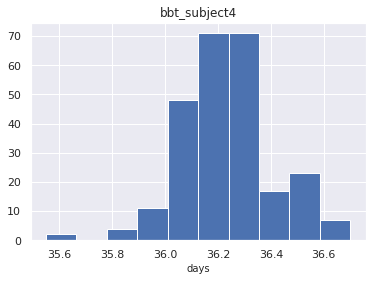

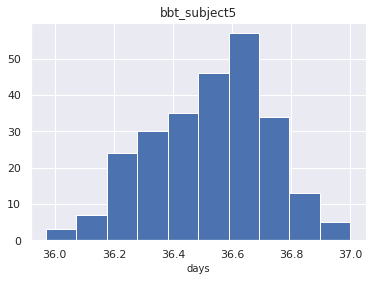

In [6]:
# plot the distribution function of temparature 
# to see if the 2 states of high and low temparature are easily separable for each subject, just for fun
for col_name in list(data.columns):
    data[[col_name]].hist()
    plt.xlabel('days', fontsize=10);

Non of the 5 subjects has clear difference in distribution of temparature for 2 phrases: high and low temparatures

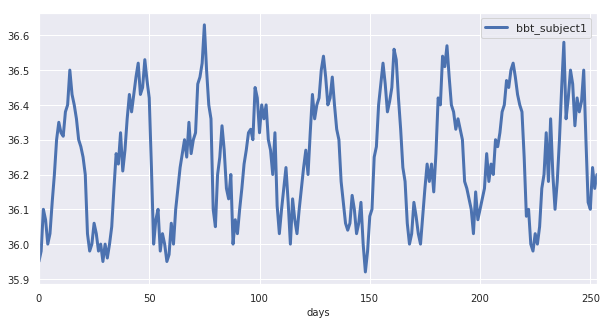

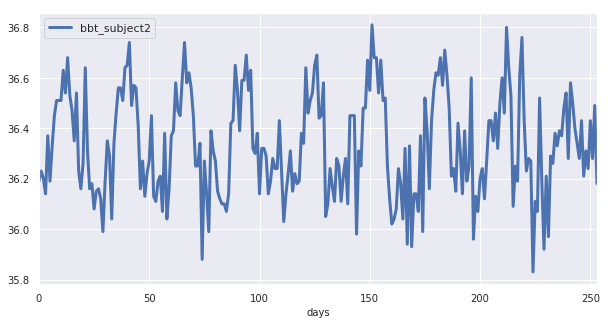

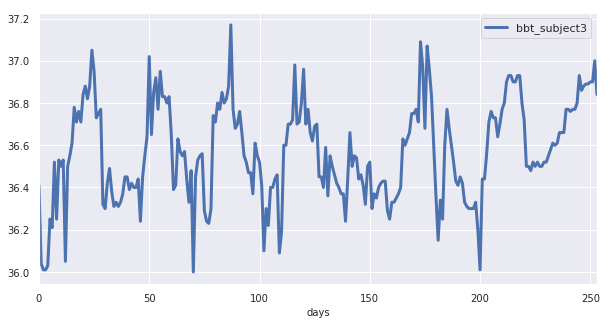

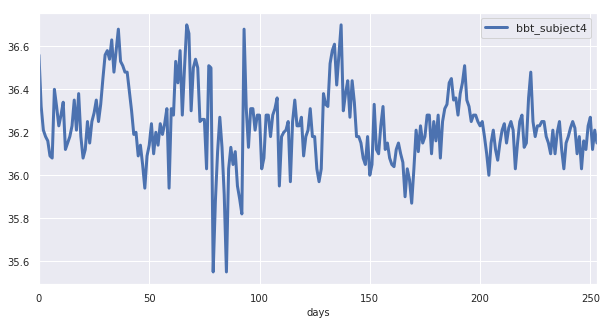

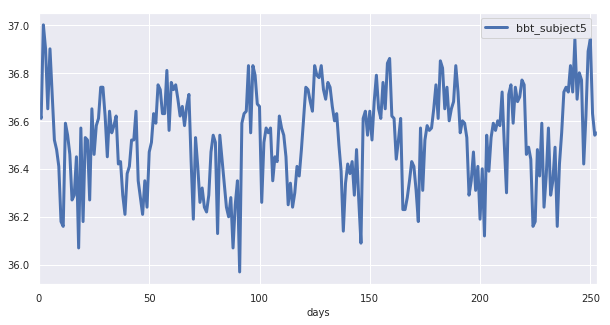

In [7]:
# plot the BBT series for each subject
for col_name in list(data.columns):
    data[[col_name]].plot(figsize=(10,5), linewidth=3, fontsize=10)
    plt.xlabel('days', fontsize=10);

Subject 1 and 2 have a clearer structure of seasonal change, while subjects 3,4 and 5 have rather random structure

# Method

Use of Kalman Filter to predict 

## Model explanation

The simplified state-space model for BBT time series includes two variables:
1. y(t) (t=1,...,T) : Basal body temparature
2. x(t) : oscillation component of BBT

### Explain daily fluctuation in BBT

* The oscillation component of BBT ( x(t) ) is a **latent state space variable** , i.e: a variable that cannot be observed
* The system model is : <br>
<img src="pictures/model_xt.png" width="430">

### Steps:
1. Compute the theoretical value of X and Error Covariance using maths formular
2. Compute measure error covariane
3. Update estimated value of X and estimated Error Covariance

### Sudo code
<img src="pictures/KalmanFilterFlow.png">

## Code

### Compute estimated y and its error covariance F

In [450]:
def kalmanFilter(y_observations, theta):
    ## Initialise parameters
    a = theta[0]
    b = theta[1]
    c = theta[2]
    f = theta[3]
    
    # Process / Estimation Errors
    sigma_x = theta[4]
    # Observation Errors
    sigma_y = theta[5]  # Uncertainty in the measurement
    
    # set B
    B = np.array([b, 0])
    delta_t = 0.01

    ## Apply Kalman Filter
    ## compute A
    radian = m.degrees(2 * m.pi * f * delta_t)
    A = np.array([[a * (m.cos(radian) - m.sin(radian)), 0],
                  [0, a * (m.sin(radian) - m.cos(radian))]])
    I = np.identity(2)

    # initialise values
    E = np.array([[sigma_y**2, 0],
                  [0, sigma_y**2]])

    init_x_est = np.array([(36.5-c)/b, 0])

    x_est = init_x_est
    x_est_series = []
    E_series = []

    # tobe compute from x
    KG_series = []
    y_est_series = []
    F_series = []
    
    for value in y_observations:
        # compute x_est and y_est from x_est_init
        x_est = A.dot(x_est)
        y_est = B.dot(x_est) + c

        # compute covariance of error from x_est
        E = A.dot(E).dot(A.T) + sigma_x*I
    #     print("cov_err_x_est", cov_err_x_est)
        # compute covariance of error from y_est
        F = B.dot(E).dot(B.T) + sigma_y
    #     print("cov_err_y_est", cov_err_y_est)

        # compute Kalman gain
        err_est = (value - y_est)
        KG = E.dot(B.T).dot(1/F)
    #     KG = err_est/(err_est + cov_err_y_est)

        # update x_est and error
        x_est = x_est + KG*err_est
        E = E - KG.dot(F).dot(KG.T)

        KG_series.append(KG)
        x_est_series.append(x_est)
        E_series.append(E)
        y_est_series.append(y_est)
        F_series.append(F)
        
    return (y_est_series, F_series, x_est_series, E_series, KG_series)

In [606]:
df = list(data['bbt_subject4'])

In [607]:
## display the result
# y_observations = list(data['bbt_subject4'])
y_observations = df
theta = [-0.7, 83, 36, 100, 0.3, 0.3]
# theta = [-0.7, 83, 36, 100, 0.3, 0.3]
(y_est_series, F_series, x_est_series, E_series, KG_series) = kalmanFilter(y_observations, theta)

res = {"y_observations": y_observations,
      "y_estimated": y_est_series,
      "F": F_series,
       "x_estimated": x_est_series,
       "E": E_series,
       "KG": KG_series}
res_df = pd.DataFrame(res)
res_df.tail()

,y_observations,y_estimated,F,x_estimated,E,KG
249,36.23,36.104379,-1.043498e+104,"[0.002771084337349336, -0.010608631838147357]","[[5.124296537009621e+100, 9.425050750311586e+1...","[0.012048192771084336, -0.022160081388122428]"
250,36.27,36.200060,2.670878e+104,"[0.0032530120481928004, 0.007677767950819626]","[[-1.3115857306375446e+101, -2.412382262689524...","[0.01204819277108434, -0.022160081388122418]"
251,36.12,36.234853,-6.836226e+104,"[0.001445783132530075, -0.004133167831155941]","[[3.357060069392299e+101, 6.174596122091587e+1...","[0.012048192771084336, -0.022160081388122428]"
252,36.21,36.104379,1.749761e+105,"[0.0025301204819276825, 0.0012545611931181564]","[[-8.592539584911533e+101, -1.580414425218117e...","[0.012048192771084336, -0.022160081388122418]"
253,36.15,36.182663,-4.478590e+105,"[0.0018072289156626537, -0.0003674291917227404]","[[2.199297450511121e+102, 4.045138671501377e+1...","[0.012048192771084336, -0.022160081388122425]"


Text(0.5, 0, 'days')

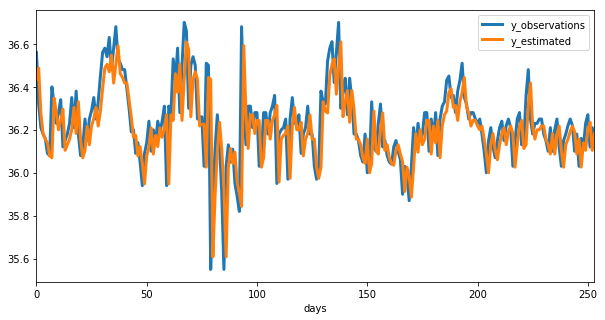

In [608]:
# visualise the result
res_df[['y_observations', "y_estimated"]].plot(figsize=(10,5), linewidth=3, fontsize=10)
plt.xlabel('days', fontsize=10)

### compute loglikelihood

In [609]:
def logL(y_observations, theta):
    # compute y_est and F
    (y_est_series, F_series, x_est_series, E_series, KG_series) = kalmanFilter(y_observations, theta)
    
    ## compute log likelihood value from y and F calculated above
    T = len(y_est_series)
    component_1 = -(T/2)*np.log(2*m.pi)
    component_2 = [] 
    inverse_F = []
    for value in F_series:
        if (value > 0.1 and value < 10**10): # condition to prevent inverse a value which is too large or too small
            inverse_F.append(1/value)
            component_2.append((np.log(1/value)))
        else:
            inverse_F.append(0)
            component_2.append(abs(1/value))
    inverse_F = np.array([inverse_F])
    component_2 = np.array([component_2])
    diff_y = np.array([np.array(y_observations)-np.array(y_est_series)])
    component_3 = (diff_y).dot(inverse_F.T).dot(diff_y)
    logL = component_1 + 0.5*sum(i for i in component_2) - 0.5*sum(i for i in component_3)
    
    return (logL[0])

In [611]:
logL(y_observations, theta)

-237.32957023412763

### Minimise loglikehood for optimal parameters

In [612]:
# run optimisation to estimate model parameters 
res = opt.minimize(fun = logL,
                   x0 = [-0.2, 50, 50, 100, 1, 1],
                   args = df, 
                   method = 'Nelder-Mead',
                   bounds = [(-1,1), (-1000, 1000), (-5000, 5000), (-5000, 5000), (-50, 50), (-50, 50)])
print(res)

 final_simplex: (array([[-3.23978774e+53, -9.54386867e+56, -1.98385920e+56,
         5.16990203e+56, -7.39536853e+53,  8.58203810e+54],
       [-2.33560849e+53, -6.88030898e+56, -1.43019196e+56,
         3.72705499e+56, -5.33142505e+53,  6.18691182e+54],
       [-2.11845697e+53, -6.24061722e+56, -1.29722090e+56,
         3.38053475e+56, -4.83573965e+53,  5.61168815e+54],
       [-1.68377297e+53, -4.96011139e+56, -1.03104548e+56,
         2.68688630e+56, -3.84349921e+53,  4.46023163e+54],
       [-1.52722539e+53, -4.49894861e+56, -9.35184767e+55,
         2.43707498e+56, -3.48615264e+53,  4.04554481e+54],
       [-1.21385558e+53, -3.57581397e+56, -7.43295166e+55,
         1.93701407e+56, -2.77083257e+53,  3.21544363e+54],
       [-1.10099824e+53, -3.24335525e+56, -6.74187834e+55,
         1.75692159e+56, -2.51321641e+53,  2.91649008e+54]]), array([-1.82614308e+105, -9.49077719e+104, -7.80802120e+104,
       -4.93251884e+104, -4.05796184e+104, -2.56351420e+104,
       -2.10899201e+104]))

In [602]:
opt_theta = res.x
opt_theta

array([-9.91584285e+53, -1.46506443e+57,  6.08564113e+55,  4.30356596e+56,
        5.98921529e+54,  1.26544898e+53])

In [603]:
## display the result
y_observations = list(data['bbt_subject1'])
theta = opt_theta
(y_est_series, F_series, x_est_series, E_series, KG_series) = kalmanFilter(y_observations, theta)

res = {"y_observations": y_observations,
      "y_estimated": y_est_series,
      "F": F_series,
       "x_estimated": x_est_series,
       "E": E_series,
       "KG": KG_series}
res_df = pd.DataFrame(res)
res_df.tail()

,y_observations,y_estimated,F,x_estimated,E,KG
249,36.12,NaN,NaN,"[nan, nan]","[[nan, nan], [nan, nan]]","[nan, nan]"
250,36.10,NaN,NaN,"[nan, nan]","[[nan, nan], [nan, nan]]","[nan, nan]"
251,36.22,NaN,NaN,"[nan, nan]","[[nan, nan], [nan, nan]]","[nan, nan]"
252,36.16,NaN,NaN,"[nan, nan]","[[nan, nan], [nan, nan]]","[nan, nan]"
253,36.20,NaN,NaN,"[nan, nan]","[[nan, nan], [nan, nan]]","[nan, nan]"


Text(0.5, 0, 'days')

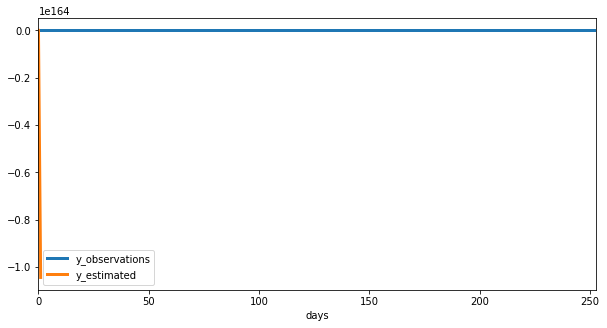

In [604]:
# visualise the result
res_df[['y_observations', "y_estimated"]].plot(figsize=(10,5), linewidth=3, fontsize=10)
plt.xlabel('days', fontsize=10)

# Result

Expected Result:
<img src="pictures/sample_result.png">